TODO collect show-seas-char sentiment df and export

TODO word embedding for each show-seas and find most similar words?

In [3]:
import sys, re, glob
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [6]:
from nltk import tokenize
import nltk
nltk.data.path.append('/media/shared_storage/data/nltk_data/')
from nltk.corpus import stopwords
from nltk.sentiment import vader

In [7]:
from gensim.models import Word2Vec, LdaModel, CoherenceModel

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [9]:
STOPWORDS = set(stopwords.words('english'))

In [123]:
show_colour_dict = {'friends': '#66c2a5',
                 'frasier': '#fc8d62',
                 'wg': '#8da0cb',
                 'willandgrace': '#8da0cb',
                 'office': '#e78ac3',
                 'seinfeld': '#a6d854',
                 'marriedwc': '#ffd92f',
                 'scrubs': '#e5c494'}

## TF-IDF from refmt files - moved to R

## Sentiment

Use VADER; keep original sentences with sw, just clean up character names and stage directions

In [13]:
#The sentences here are actually 'lines', which is OK as the sentences within a line should be related.
def clean_ep_sentences(ep_text, STOPWORDS):
    clean_ep_text = []
    for line in ep_text:
        line = line.rstrip('\n')
        
        #remove stage directions
        line = re.sub('\(.*\)', '', line)
        line = re.sub('\[.*\]', '', line)
        
        if line[:5] == 'Scene' or line[:5] == '(Note':
            continue
        elif line[:7] == 'The One':
            continue
        elif len(line) > 0:
            line = ' '.join(line.split(':')[1:]).strip()
            words = line.split(' ')
            words_clean = [re.sub('[^a-zA-Z0-9_\\s]', '', word.lower()) for word in words]
            line = ' '.join([word for word in words_clean if word not in STOPWORDS])
            #line = ' '.join([word for word in words_clean])
            clean_ep_text.append(line)
    return clean_ep_text

In [29]:
seasons_and_clean_sentences = defaultdict(lambda : [])
for refmt_file in sorted(glob.glob('office_transcripts/refmt*')):
    season = int(refmt_file[-8:-6])
    
    with open(refmt_file, 'r', encoding='ISO-8859-1') as f:
        ep_sentences = f.readlines()

    seasons_and_clean_sentences[season] += clean_ep_sentences(ep_sentences, [])

In [39]:
v_sent = vader.SentimentIntensityAnalyzer()

In [40]:
for season, sentences in seasons_and_clean_sentences.items():
    print('Season {:g} total lines = {:5g}; mean compound sentiment = {:.3f}'.format(
        season, len(sentences), 
        np.mean([v_sent.polarity_scores(s)['compound'] for s in sentences]))
    )

Season 1 total lines =  1501; mean compound sentiment = 0.141
Season 2 total lines =  5925; mean compound sentiment = 0.116
Season 3 total lines =  6414; mean compound sentiment = 0.114
Season 4 total lines =  4798; mean compound sentiment = 0.116
Season 5 total lines =  7785; mean compound sentiment = 0.094
Season 6 total lines =  7679; mean compound sentiment = 0.104
Season 7 total lines =  7472; mean compound sentiment = 0.105
Season 8 total lines =  6710; mean compound sentiment = 0.110
Season 9 total lines =  7149; mean compound sentiment = 0.120


In [41]:
for season, sentences in seasons_and_clean_sentences.items():
    print('Season {:g} mean pos, neg sentiment = {:.3f} vs {:.3f}'.format(
        season, 
        np.mean([v_sent.polarity_scores(s)['pos'] for s in sentences]),
        np.mean([v_sent.polarity_scores(s)['neg'] for s in sentences]))
    )

Season 1 mean pos, neg sentiment = 0.196 vs 0.075
Season 2 mean pos, neg sentiment = 0.187 vs 0.077
Season 3 mean pos, neg sentiment = 0.186 vs 0.072
Season 4 mean pos, neg sentiment = 0.182 vs 0.071
Season 5 mean pos, neg sentiment = 0.174 vs 0.077
Season 6 mean pos, neg sentiment = 0.182 vs 0.076
Season 7 mean pos, neg sentiment = 0.177 vs 0.078
Season 8 mean pos, neg sentiment = 0.173 vs 0.080
Season 9 mean pos, neg sentiment = 0.179 vs 0.077


Split by character

In [14]:
def get_clean_ep_sentences_by_character(ep_text, STOPWORDS):
    
    char_sentence_dict = defaultdict(lambda : [])
    
    for line in ep_text:
        if 'DOCTYPE' in line or 'style type=' in line:
            continue
        
        line = line.rstrip('\n')
        
        #remove stage directions
        line = re.sub('\(.*\)', '', line)
        line = re.sub('\[.*\]', '', line)
        
        if line[:5] == 'Scene' or line[:5] == '(Note':
            continue
        elif line[:7] == 'The One':
            continue
        elif len(line) > 0:
            character = line.split(':')[0].lower().strip()
            line = ' '.join(line.split(':')[1:]).strip()
            words = line.split(' ')
            words_clean = [re.sub('[^a-zA-Z0-9_\\s]', '', word.lower()) for word in words]
            line = ' '.join([word for word in words_clean if word not in STOPWORDS])
            
            char_sentence_dict[character] += [line]
    return char_sentence_dict

In [43]:
season_sentences_by_char = defaultdict(lambda : {})
for refmt_file in sorted(glob.glob('frasier_transcripts/refmt*')):
    season = int(refmt_file[-8:-6])
    ep_num = int(refmt_file[-6:-4])

    with open(refmt_file, 'r', encoding='ISO-8859-1') as f:
        ep_sentences = f.readlines()

    season_sentences_by_char[season][ep_num] = get_clean_ep_sentences_by_character(ep_sentences, [])

In [332]:
def get_seas_ep_char_sentiments(file_list, vader_sentiment_analyzer):
    
    print('Getting char lines for {:d} files'.format(len(file_list)))
    season_sentences_by_char = defaultdict(lambda : {})
    for refmt_file in file_list:
        season = int(refmt_file[-8:-6])
        ep_num = int(refmt_file[-6:-4])

        with open(refmt_file, 'r', encoding='ISO-8859-1') as f:
            ep_sentences = f.readlines()

        season_sentences_by_char[season][ep_num] = get_clean_ep_sentences_by_character(ep_sentences, [])
    
    print('Getting sentiment for each line')
    seas_ep_char_sentiments = pd.DataFrame()

    for season in list(season_sentences_by_char.keys()):
        print('Season {:d}'.format(season))
        for ep in season_sentences_by_char[season].keys():
            for char in season_sentences_by_char[season][ep].keys():
                sent_score = np.mean([vader_sentiment_analyzer.polarity_scores(s)['compound'] \
                                      for s in season_sentences_by_char[season][ep][char]])

                seas_ep_char_sentiments = pd.concat([seas_ep_char_sentiments,
                                                     pd.DataFrame({'season': [season], 'ep': [ep], 
                                                                   'char': [char], 
                                                                   'n_lines': len(season_sentences_by_char[season][ep][char]),
                                                                   'sent': [sent_score]})])

    seas_ep_char_sentiments = seas_ep_char_sentiments.reset_index()
    seas_ep_char_sentiments = seas_ep_char_sentiments.drop('index', axis=1)
    
    return seas_ep_char_sentiments

In [45]:
seas_ep_char_sentiments = get_seas_ep_char_sentiments(glob.glob('seinfeld_transcripts/refmt*txt'),
                                                      vader.SentimentIntensityAnalyzer())

Getting char lines for 176 files
Getting sentiment for each line
Season 0
Season 1
Season 2
Season 3
Season 4
Season 5
Season 6
Season 7
Season 8
Season 9


In [46]:
seas_ep_char_sentiments.head()

,char,ep,n_lines,season,sent
0,is,1,1,0,0.892200
1,laura and jerry,1,1,0,0.000000
2,got,1,1,0,0.000000
3,waitress,1,3,0,0.181967
4,stands by the dryer again and secretly opens it,1,1,0,-0.153100


In [47]:
seas_ep_char_sentiments.groupby(['char']).agg({'ep': len, 'sent':np.mean}).reset_index()\
    .sort_values('ep', ascending=False).head(6)

,char,sent,ep
436,jerry,0.056614,176
322,george,0.067940,175
502,kramer,0.091397,174
254,elaine,0.064434,173
714,newman,0.070542,49
566,man,0.078239,44


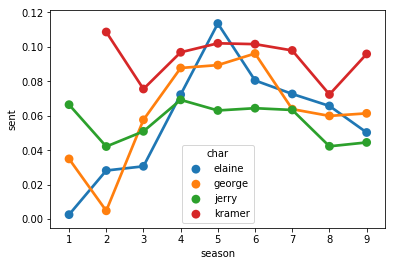

In [52]:
#Keep only the main characters - there are many 1 line chars, some mistakes
plot_df = seas_ep_char_sentiments.groupby(['season','char']).agg({'sent': np.mean,
                                                                  'n_lines': np.sum}).reset_index()
plot_df = plot_df[plot_df.n_lines > 100]  #100 lines per season
#plot_df = plot_df[plot_df.char.isin(['frasier','niles','daphne','martin','roz'])]
plot_df = plot_df[plot_df.char.isin(['jerry','elaine','george','kramer'])]

sns.pointplot(x='season',y='sent', hue='char',
              data = plot_df,
              join = True)

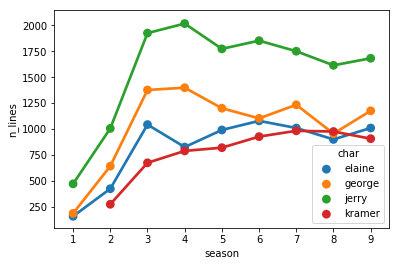

In [53]:
sns.pointplot(x='season',y='n_lines', hue='char',
              data = plot_df,
              join = True)

Get all seas-ep-char sentiment for all shows and save

In [ ]:
#Office
#Jim + Pam sentiment becomes same and increases from s5 onwards
#Michael decreases from s4 onwards
#Dwight notably more negative

#Seinfeld
#Kramer highest; generally lower sent than other shows?

#MarriedWC
#Al not noticeably lower than others

Run for all shows and save out, for plotting in R.

In [333]:
for show in ['friends','frasier','wg','office','seinfeld','marriedwc','scrubs']:
    print('Doing %s' % show)
    get_seas_ep_char_sentiments(glob.glob('%s_transcripts/refmt*txt' % show),
                                vader.SentimentIntensityAnalyzer())\
        .to_csv('./seas_ep_char_sentiments_%s.csv' % show)

Doing friends
Getting char lines for 227 files
Getting sentiment for each line
Season 1
Season 2
Season 3
Season 4
Season 5
Season 6
Season 7
Season 8
Season 9
Season 10
Doing frasier
Getting char lines for 263 files
Getting sentiment for each line
Season 1
Season 2
Season 3
Season 4
Season 5
Season 6
Season 7
Season 8
Season 9
Season 10
Season 11
Doing wg
Getting char lines for 185 files
Getting sentiment for each line
Season 1
Season 2
Season 3
Season 4
Season 5
Season 6
Season 7
Season 8
Doing office
Getting char lines for 186 files
Getting sentiment for each line
Season 1
Season 2
Season 3
Season 4
Season 5
Season 6
Season 7
Season 8
Season 9
Doing seinfeld
Getting char lines for 176 files
Getting sentiment for each line
Season 0
Season 1
Season 2
Season 3
Season 4
Season 5
Season 6
Season 7
Season 8
Season 9
Doing marriedwc
Getting char lines for 134 files
Getting sentiment for each line
Season 1
Season 2
Season 3
Season 4
Season 5
Season 6
Season 7
Season 8
Season 9
Season 10
Sea

## DTM for each character and plot with T-SNE/PCs

### Calculate combined DTM

In [20]:
def get_full_char_dtm(ep_file_list, min_n_lines = 1000, vectorizer_max_features = 500):

    char_text_df_list = []

    for ep_file in ep_file_list:
        with open(ep_file, 'r', encoding='ISO-8859-1') as f:
            ep_text = f.readlines()
        char_ep_sentences = get_clean_ep_sentences_by_character(ep_text, STOPWORDS)

        char_text_df = pd.DataFrame({'char': list(char_ep_sentences.keys()),
                                     'num_lines': [len(char_ep_sentences[c]) for c in char_ep_sentences.keys()],
                                     'text': [' '.join(char_ep_sentences[c]) for c in char_ep_sentences.keys()]})
        char_text_df = char_text_df[char_text_df.num_lines >= 3].reset_index()

        char_text_df_list.append(char_text_df)
        
    char_text_df = pd.concat(char_text_df_list)\
        .groupby('char').agg({'num_lines': sum,
                              'text': lambda l: ' '.join(list(l))}).reset_index()
    char_text_df['num_words'] = char_text_df.text.apply(lambda t: len(t.split(' ')))
    
    #for now limit to main characters
    char_text_df = char_text_df[char_text_df.num_lines >= min_n_lines].reset_index()
    
    cv = CountVectorizer(ngram_range = (1,1), max_features = vectorizer_max_features)
    char_dtm = cv.fit_transform(char_text_df.text).toarray()
    
    char_dtm = pd.DataFrame(char_dtm, columns = cv.get_feature_names())
    char_dtm['char_name'] = char_text_df['char']
    char_dtm['num_lines'] = char_text_df['num_lines']
    char_dtm['num_words'] = char_text_df['num_words']
    
    return char_dtm

In [11]:
#Individual show dtms:

#Rachel saying Ross is most common pair by far (482 times = twice per episode)
#Ross, Joey were most commonly said names; girls less common but short forms make up the difference
#  (756 Rachel vs 367 Rach; 742 Phoebe vs 346 Pheebs)
#Least common pair is Chandler saying Rachel
#Self reference totals are 50-100 each

#(Dropped will in WG): Most common is Will saying Grace; Jack says Jack relatively often

In [42]:
show_char_dtms = []
char_show_dict = {}
for show in ['friends','frasier','wg','office','seinfeld','marriedwc','scrubs']:
    res = get_full_char_dtm(glob.glob('%s_transcripts/refmt*txt' % show), vectorizer_max_features=500)
    
    for char in res.char_name:
        if char in char_show_dict.keys():
            print('CLASH!')
        else:
            char_show_dict[char] = show
            
    show_char_dtms.append(res)
    
common_word_cols = set.intersection(*[set(df.columns) for df in show_char_dtms])
common_word_cols = list(common_word_cols)
show_char_dtms = pd.concat([df[common_word_cols] for df in show_char_dtms])

show_char_dtms = show_char_dtms[show_char_dtms['char_name'] != "j.d.'s narration"]

for word_col in [c for c in common_word_cols if c not in ['char_name','num_lines','num_words']]:
    show_char_dtms[word_col] = show_char_dtms[word_col] / show_char_dtms['num_words']
    
show_char_dtms = show_char_dtms.reset_index()

In [43]:
#This leaves 297 common features
show_char_dtms.shape

(42, 297)

In [44]:
#We have a list of main character names for use later
char_show_dict.keys()

dict_keys(['monica', 'joey', 'turk', 'martin', 'chandler', 'bud', 'ross', 'kelly', 'jerry', 'niles', 'angela', 'michael', 'dwight', 'frasier', 'rachel', 'j.d.', 'pam', 'peggy', 'elaine', 'will', 'ryan', 'karen', 'roz', 'jim', 'dr. kelso', 'steve', 'kramer', 'carla', 'darryl', 'oscar', 'dr. cox', "j.d.'s narration", 'marcy', 'george', 'jack', 'grace', 'andy', 'phoebe', 'elliot', 'daphne', 'erin', 'kevin', 'al'])

### Plot correlation between each character's DTMs

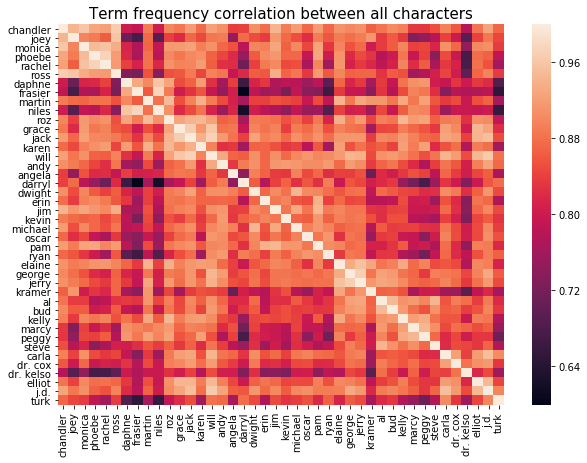

In [124]:
#Char names are already removed because they are not common to all dtms

fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(np.corrcoef(show_char_dtms[[c for c in common_word_cols \
                                        if c not in ['char_name','num_lines','num_words']+list(show_char_dtms.char_name)]]),
            xticklabels = show_char_dtms.char_name,
            yticklabels = show_char_dtms.char_name,
            ax = ax)
plt.title('Term frequency correlation between all characters', fontsize=15)
plt.savefig('post2_character_dtm_correlation_heatmap.png')

#Can see clusters of high corr within shows
#Highest corrs are Frasier-Niles, Phoebe-Rachel, Jack-Will, Jack-Grace, Jerry-George
#Lowest are Frasier-Darryl, Niles-Darryl, Daphne-Darryl, Frasier-Ryan

In [67]:
tmp = pd.DataFrame(np.corrcoef(show_char_dtms[[c for c in common_word_cols \
                                               if c not in ['char_name','num_lines','num_words']+list(show_char_dtms.char_name)]]), 
                   columns = show_char_dtms['char_name'], 
                   index=show_char_dtms['char_name']).reset_index()

for col in tmp.columns[1:]:
    corrs = tmp[col].tolist()
    for i in range(len(corrs)):
        #if 0.999 > corrs[i] > 0.96:
        #    print(col, tmp.char_name[i], np.round(corrs[i],3))
        if corrs[i] < 0.67: # and col != "j.d.'s narration" and tmp.char_name[i] != "j.d.'s narration":
            print(col, tmp.char_name[i], np.round(corrs[i],3))

daphne darryl 0.662
frasier darryl 0.599
frasier ryan 0.665
frasier turk 0.649
niles darryl 0.619
niles turk 0.656
darryl daphne 0.662
darryl frasier 0.599
darryl niles 0.619
ryan frasier 0.665
turk frasier 0.649
turk niles 0.656


In [65]:
#The lowest overall correlations with anyone else are
#  0.79 for kelso, frasier, 0.80 for darryl
for col in tmp.columns[1:]:
    print(col, tmp[col].mean())

chandler 0.8877381432131182
joey 0.8440333482990809
monica 0.8763854180488315
phoebe 0.8529371178687628
rachel 0.8506122485183655
ross 0.855848146305242
daphne 0.8228771583209108
frasier 0.7928710122716008
martin 0.8698335869331612
niles 0.8078208507170023
roz 0.890373444820712
grace 0.8767774148719897
jack 0.901043886361194
karen 0.8685172551098245
will 0.8989876866935964
andy 0.870212662286584
angela 0.835363127775681
darryl 0.7997713728690827
dwight 0.8719475529401818
erin 0.8477502922437916
jim 0.8693573731263581
kevin 0.8490618761951138
michael 0.8665265504832158
oscar 0.8425514259381538
pam 0.8675865100144977
ryan 0.8338932674015435
elaine 0.8852892597928985
george 0.879810318681681
jerry 0.8857560889570634
kramer 0.8193728049046062
al 0.8649670789202224
bud 0.862225528969021
kelly 0.873135380223467
marcy 0.8486827268126864
peggy 0.8396368127516829
steve 0.8329135114300916
carla 0.8671211672978429
dr. cox 0.8547493189560458
dr. kelso 0.794115711581064
elliot 0.8710702862597726
j.

### Plot PCs

In [128]:
def plot_2d_pcs(df, label_col = 'season', my_2d_pca = None):
    fig, ax = plt.subplots(figsize=(8,8))
    ax = df.plot(x='dim0', y='dim1', kind='scatter',
                 color=df.show_colour.tolist(),
                 ax=ax)
    if my_2d_pca is not None:
        ax.set_xlabel('PC 1 ({:.0f}% of variance)'.format(my_2d_pca.explained_variance_ratio_[0]*100), fontsize=12)
        ax.set_ylabel('PC 2 ({:.0f}% of variance)'.format(my_2d_pca.explained_variance_ratio_[1]*100), fontsize=12)

    for key, row in df.iterrows():
        ax.annotate(row[label_col], xy = (row['dim0']+0.0003, row['dim1']+0.0003),
                    fontsize=10)
    
    plt.title('Principal component projection of character term frequencies',
              fontsize=15)
    plt.tight_layout()
    #plt.show()

In [129]:
my_2d_pca = PCA(n_components = 2, whiten=False).fit(show_char_dtms[[c for c in common_word_cols \
                                                    if c not in ['char_name','num_lines','num_words']+list(show_char_dtms.char_name)]])

dtms_2d = my_2d_pca.transform(show_char_dtms[[c for c in common_word_cols \
                                              if c not in ['char_name','num_lines','num_words']+list(show_char_dtms.char_name)]])
dtms_2d = pd.DataFrame(dtms_2d, index=show_char_dtms.char_name).reset_index()
dtms_2d['show'] = dtms_2d.char_name.apply(lambda c: char_show_dict[c])
dtms_2d.columns = ['char_name', 'dim0', 'dim1', 'show']

dtms_2d['show_colour'] = dtms_2d.show.apply(lambda s: show_colour_dict[s])

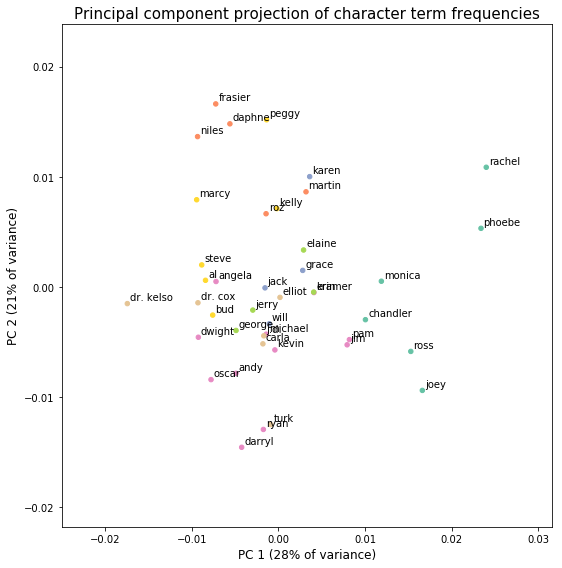

In [130]:
plot_2d_pcs(dtms_2d, label_col = 'char_name', my_2d_pca = my_2d_pca)
plt.savefig('post2_character_dtm_pca_scatter.png')

#Characters from same show stay together; Jim+Pam identical;
#  Friends characters quite different, Jim+Pam closest to them

### And t-SNE

In [121]:
dtms_tsne = TSNE(n_components = 2,
                 perplexity = 10,
                 learning_rate = 50,
                 random_state = 8842).fit_transform(show_char_dtms[[c for c in common_word_cols \
                                                             if c not in ['char_name','num_lines','num_words']+list(show_char_dtms.char_name)]])
dtms_tsne = pd.DataFrame(dtms_tsne, index=show_char_dtms.char_name).reset_index()
dtms_tsne['show'] = dtms_tsne.char_name.apply(lambda c: char_show_dict[c])
dtms_tsne.columns = ['char_name', 'dim0', 'dim1', 'show']

dtms_tsne['show_colour'] = dtms_tsne.show.apply(lambda s: show_colour_dict[s])

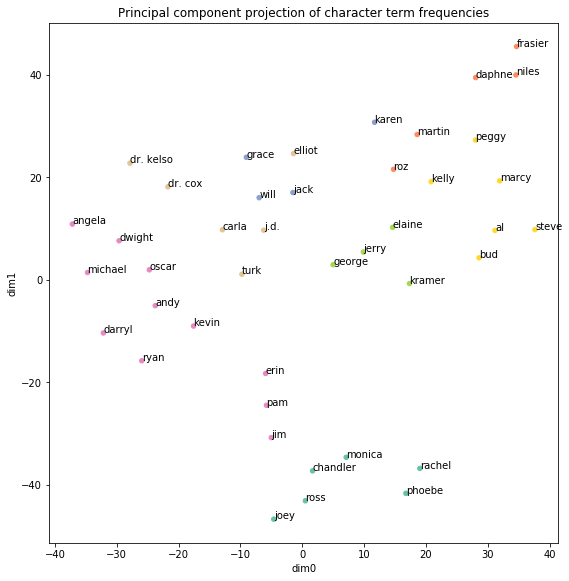

In [122]:
plot_2d_pcs(dtms_tsne, label_col = 'char_name')

#Sensitive to t-SNE parameters, but characters from same show tend to stay together
#Fairly consistent with PCA

### Other word comparisons

In [310]:
from matplotlib.patches import Arc

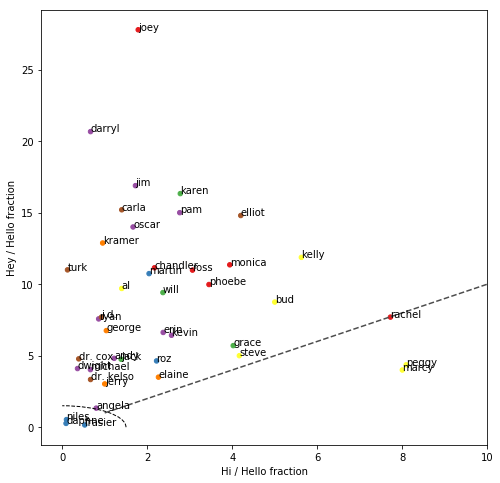

In [336]:
#Could do scatter of hello/hi vs hey/hi
#show_char_dtms[['hello','hi','hey','char_name']].sort_values('hello', ascending=False).head(10)

greeting_dtm = show_char_dtms[['hello','hi','hey','char_name']].reset_index()
greeting_dtm['hi_over_hello'] = greeting_dtm['hi'] / greeting_dtm['hello']
greeting_dtm['hey_over_hello'] = greeting_dtm['hey'] / greeting_dtm['hello']
greeting_dtm['show'] = greeting_dtm.char_name.apply(lambda c: char_show_dict[c])
greeting_dtm['show_colour'] = greeting_dtm.show.apply(lambda s: show_colour_dict[s])

fig, ax = plt.subplots(figsize=(8,8))
ax = greeting_dtm.plot(x='hi_over_hello', y='hey_over_hello', kind='scatter',
                       color=greeting_dtm.show_colour.tolist(),
                       ax=ax)
ax.set_xlabel('Hi / Hello fraction')
ax.set_ylabel('Hey / Hello fraction')

for key, row in greeting_dtm.iterrows():
    ax.annotate(row['char_name'], xy = (row['hi_over_hello'], row['hey_over_hello']))
ax.plot((1,10), (1,10), ls="--", c=".3")
arc = Arc((0, 0),
          3, 3,  # ellipse width and height
          theta1=0, theta2=90, linestyle='dashed')
ax.add_patch(arc)
plt.xlim(-0.5,10)
plt.show()

#Joey, Darryl (Office generally) prefer Hey; Rachel, Peggy, Marcy prefer Hi;
#  Frasier, Niles, Daphne, Angela, Jerry ('...Newman'?) prefer Hello
#  Average line is ~3x as many Hey as Hi

### Split by season and track mean corr between characters in same show. 

Lower correlation is probably better writing. At least it should be similar to the overall correlation between characters. Maybe; if the characters were real people, groups of friends would tend to speak more similarly than random samples of people.

In [326]:
#np.corrcoef here calculates corr matrix for each row against other rows, so includes 1s
print('Between-char correlation within shows:')
for show in ['friends','frasier','wg','office','seinfeld','marriedwc','scrubs']:
    tmp = np.corrcoef(show_char_dtms[[c for c in common_word_cols \
                                            if c not in ['char_name','num_lines','num_words']+list(show_char_dtms.char_name)]]\
                      .loc[show_char_dtms['char_name'].apply(lambda c: char_show_dict[c]) == show])
    print(np.mean([el for el in tmp.flatten() if el != 1]))
    start_i = end_i
    
print('and overall:')
tmp = np.corrcoef(show_char_dtms[[c for c in common_word_cols \
                                            if c not in ['char_name','num_lines','num_words']+list(show_char_dtms.char_name)]])
print(np.mean([el for el in tmp.flatten() if el != 1]))
    
#We see that within show corrs are 0.88-0.95; highest for WG, lowest for Office (which has most characters)
#And overall between all characters is 0.86

Between-char correlation within shows:
0.9323612159077833
0.9260447600562546
0.953243812044782
0.8822678530869962
0.940342968159615
0.9120078781487665
0.8823638889587645
and overall:
0.8532146673091181


In [329]:
all_res = []

for i in range(1,8):
    season = '%02i' % i
    print(season)
    
    show_char_dtms = []
    for show in ['friends','frasier','wg','office','seinfeld','marriedwc','scrubs']:
        
        if i > 5 and show=='scrubs':
            continue
        
        res = get_full_char_dtm(glob.glob('%s_transcripts/refmt_%s*txt' % (show,season)), min_n_lines = 100)
        #print(res.shape)
        res = res[res['char_name'].isin(char_show_dict.keys())]
        if show=='office':
            res = res[res['char_name'] != 'kelly']
        #print(res.shape)

        show_char_dtms.append(res)

    common_word_cols = set.intersection(*[set(df.columns) for df in show_char_dtms])
    common_word_cols = list(common_word_cols)
    show_char_dtms = pd.concat([df[common_word_cols] for df in show_char_dtms])

    for word_col in [c for c in common_word_cols if c not in ['char_name','num_lines','num_words']]:
        show_char_dtms[word_col] = show_char_dtms[word_col] / show_char_dtms['num_words']
        
    #np.corrcoef here calculates corr matrix for each row against other rows, so would includes 1s unless removed
    #print('Between-char correlation within shows:')
    a, b = [], []
    for show in ['friends','frasier','wg','office','marriedwc','seinfeld','scrubs']:
        
        if i > 5 and show=='scrubs':
            continue
            
        tmp = np.corrcoef(show_char_dtms[[c for c in common_word_cols \
                                                if c not in ['char_name','num_lines','num_words']+list(show_char_dtms.char_name)]]\
                          .loc[show_char_dtms['char_name'].apply(lambda c: char_show_dict[c]) == show])
        #print(np.mean([el for el in tmp.flatten() if el != 1]))
        a.append(show)
        b.append(np.mean([el for el in tmp.flatten() if el != 1]))
        
    #overall corr:
    tmp = np.corrcoef(show_char_dtms[[c for c in common_word_cols \
                                                if c not in ['char_name','num_lines','num_words']+list(show_char_dtms.char_name)]])
    a.append('overall')
    b.append(np.mean([el for el in tmp.flatten() if el != 1]))

    all_res.append(pd.DataFrame({'show': a, 'season': [season]*len(a), 'in_show_corr': b}))

all_res = pd.concat(all_res)

01
02
03
04
05
06
07


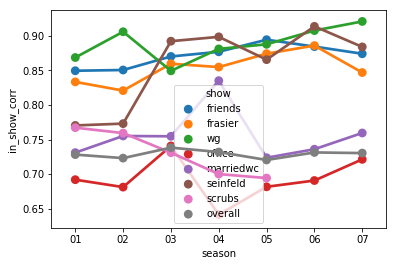

In [330]:
sns.pointplot(x='season',y='in_show_corr', hue='show',
              data = all_res,
              join = True)

## Word embeddings

Read in pre-trained vectors

In [7]:
from gensim.models import KeyedVectors

In [8]:
pretr_wv = KeyedVectors.load_word2vec_format('/media/shared_storage/data/text_data/GoogleNews-vectors-negative300.bin.gz', binary=True)

Read in an process sentences from one show

In [337]:
seasons_and_clean_sentences = defaultdict(lambda : [])

transcript_dirs = glob.glob('*_transcripts')

for transcript_dir in transcript_dirs:
    for refmt_file in sorted(glob.glob(transcript_dir + '/refmt*')):
        season = int(refmt_file[-8:-6])
        show = transcript_dir.split('_')[0]

        with open(refmt_file, 'r', encoding='ISO-8859-1') as f:
            ep_sentences = f.readlines()

        seasons_and_clean_sentences['{:s} s{:d}'.format(show,season)] += clean_ep_sentences(ep_sentences, [])

In [74]:
seasons_and_clean_sentences['friends s1'][:5]

['theres nothing to tell hes just some guy i work with',
 'cmon youre going out with the guy theres gotta be something wrong with him',
 'all right joey be nice so does he have a hump a hump and a hairpiece',
 'wait does he eat chalk',
 'just cause i dont want her to go through what i went through with carl oh']

In [338]:
def get_list_of_sentence_vectors(list_of_sentences, wv_model, 
                                 exclude_char_names=False, char_name_list=None):
    
    if exclude_char_names and char_name_list is not None:
        list_of_sentences = [' '.join([w for w in s.split(' ') if w not in char_name_list]) \
                                 for s in list_of_sentences]
    
    list_of_sentences = [s for s in list_of_sentences if \
                         sum([w in wv_model.vocab.keys() for w in s.split(' ')])]
    
    l_of_v = [np.array([wv_model[w] for w in sentence.split(' ') if w in wv_model.vocab.keys()]).mean(axis=0) \
              for sentence in list_of_sentences]
    
    return l_of_v

In [339]:
show_seasons_labels, show_seasons_embedding = [], []
for k,v in seasons_and_clean_sentences.items():
    show_seasons_labels.append(k)
    show_seasons_embedding.append(np.array(get_list_of_sentence_vectors(v, pretr_wv,
                                                                        exclude_char_names = True,
                                                                        char_name_list = list(char_show_dict.keys())
                                                                       )
                                          ).mean(axis=0)
                                 )

show_seasons_embedding = np.stack(show_seasons_embedding)

Plot the season vector representations in 2-d using PCA. 

Including char names: it shows MWC and Friends being most dissimilar; Seinfeld s0 an outlier; Seinfeld moving towards MWC over the years;

Excluding char names: similar

As with characters above, Friends language seems quite different to the others

TODO update colours and just print seas number

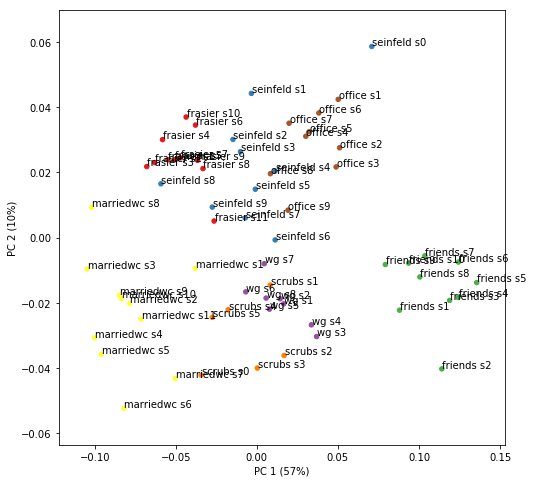

In [340]:
my_2d_pca = PCA(n_components = 2, whiten=False).fit(show_seasons_embedding)

wvs_2d = my_2d_pca.transform(show_seasons_embedding)

wvs_2d = pd.DataFrame(wvs_2d, index = show_seasons_labels).reset_index()
wvs_2d.columns = ['season', 'dim0', 'dim1']
wvs_2d['show'] = wvs_2d.season.apply(lambda s: s.split(' ')[0])

wvs_2d['show_colour'] = wvs_2d.show.apply(lambda s: show_colour_dict[s])

plot_2d_pcs(wvs_2d, my_2d_pca = my_2d_pca)

TODO check if there is any pattern in direction of movement in PC1 or PC2 by season.

Or same thing with T-SNE:

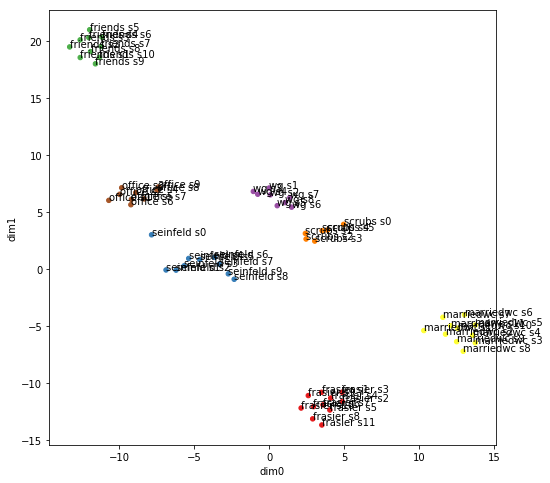

In [341]:
wvs_tsne = TSNE(n_components = 2,
                 perplexity = 10,
                 learning_rate = 50,
                 random_state = 8842).fit_transform(show_seasons_embedding)

wvs_2d = pd.DataFrame(wvs_tsne, index = show_seasons_labels).reset_index()
wvs_2d.columns = ['season', 'dim0', 'dim1']
wvs_2d['show'] = wvs_2d.season.apply(lambda s: s.split(' ')[0])

show_colour_dict = {show: sns.color_palette('Set1', n_colors=7)[i] \
                    for (i, show) in enumerate(wvs_2d.show.unique().tolist())}
wvs_2d['show_colour'] = wvs_2d.show.apply(lambda s: show_colour_dict[s])

plot_2d_pcs(wvs_2d)

OR: use all sitcoms and all sentences to train model. Then project each show-season onto the model vectors to somehow show style differences in words. But need to demonstrate that model is sensible first.